Author:
        
        KIM, JeongYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.

<a id="1"></a>
> <h1 style = 'font-family: Times New Roman'><b> <b style = 'color: #42c2f5'></b> Train CCNet with Titanic dataset</b></h1>

- Data Source: https://www.kaggle.com/competitions/titanic/data


<a id="1"></a>
> <h2 style = 'font-family: Times New Roman'><b> <b style = 'color: #42c2f5'>1.</b> Import Necessary Libraries </b></h2>

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore") # Ignore warnings

path_append = "../../"
sys.path.append(path_append)  # Go up one directory from where you are.

# Set random seed for reproducibility
from nn.utils.init import set_random_seed
set_random_seed(0) 

<a id="1"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #42c2f5'>1-1.</b>Load the dataset </b></h3>

In [2]:
import pandas  as pd
dataset_name = "titanic"
df = pd.read_csv(path_append + f'../data/titanic/train.csv') # place the dataset in the 'data' folder
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<a id="2"></a>
> <h2 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'>2.</b> Data Preprocess </b></h2>

Use CCNet’s `auto_preflow_dataframe` function to conveniently preprocess the dataframe.

In [3]:
from tools.preprocessing.data_frame import auto_preprocess_dataframe

target_columns = ['Survived']
drop_columns = ['PassengerId', 'Name', 'Cabin', 'Ticket']
encode_columns = ['Sex', 'Embarked', 'Pclass']
df, description = auto_preprocess_dataframe(df, target_columns, drop_columns, encode_columns)

Dropped columns: PassengerId, Name, Cabin, Ticket
Number of missing values in each column:
Age         177
Embarked      2
dtype: int64
Number of rows dropped due to missing values: 179

Column 'Embarked' has 3 unique values.
Column 'Pclass' has 3 unique values.
Column 'Sex' has 2 unique values.


,Min,Max,Mean,Std,Null Count,Scaled,Encoded
Age,-2.587574,4.459119,3.742325e-16,1.283328,0,Minmax,None
SibSp,-0.514045,4.485955,-9.979533e-18,0.930692,0,None,None
Parch,-0.432584,5.567416,-9.979533e-18,0.854181,0,None,None
Fare,-0.627088,19.907148,7.583728e-01,2.121790,0,Robust,None
Sex,0.000000,1.000000,6.362360e-01,0.481420,0,None,One-hot
Embarked_C,0.000000,1.000000,1.825843e-01,0.386597,0,None,None
Embarked_Q,0.000000,1.000000,3.932584e-02,0.194506,0,None,None
Embarked_S,0.000000,1.000000,7.780899e-01,0.415823,0,None,None
Pclass_1,0.000000,1.000000,2.584270e-01,0.438078,0,None,One_hot
Pclass_2,0.000000,1.000000,2.429775e-01,0.429183,0,None,One_hot


In [4]:
import torch
from sklearn.model_selection import train_test_split
from tools.preprocessing.template_dataset import TemplateDataset

# Split the data into train and test
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)
# predict the next value in the sequence
train_df_x = train_df.iloc[:, :-1] # all columns except the last one
train_df_y = train_df.iloc[:, -1:] # only the last column

test_df_x = test_df.iloc[:, :-1] # all columns except the last one
test_df_y = test_df.iloc[:, -1:] # only the last column

print('train df shape: ', train_df.shape)
print('test df shape: ', test_df.shape)

# Create the datasets with TemplateDataset class
trainset = TemplateDataset(train_df_x, train_df_y)
testset = TemplateDataset(test_df_x, test_df_y)

train df shape:  (498, 12)
test df shape:  (214, 12)


<a id="2"></a>
> <h2 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'>3.</b> Modeling: CCNet </b></h2>

In [5]:
from tools.setting.data_config import DataConfig
from tools.setting.ml_params import MLParameters
from trainer_hub import TrainerHub

# Set data configuration from the DataConfig class
num_features = description['num_features']
num_classes = description['num_classes']
data_config = DataConfig(dataset_name = dataset_name, task_type='binary_classification', obs_shape=[num_features], label_size=num_classes, explain_size=7)

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(ccnet_network = 'tabnet', encoder_network = 'none')
ml_params.training.num_epoch = 1
ml_params.training.batch_size = 32
ml_params.model.ccnet_config.num_layers = 4

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Initialize the TrainerHub class with the training configuration, data configuration, device, and use_print and use_wandb flags
trainer_hub = TrainerHub(ml_params, data_config, device, use_print=False, use_wandb=False) 

Trainer Name: causal_trainer


ModelParameters Parameters:


,ccnet_config,ccnet_network,encoder_config,encoder_network
0,See details below,tabnet,None,none



Detailed ccnet_config Configuration:


,ccnet_config_model_name,ccnet_config_num_layers,ccnet_config_d_model,ccnet_config_dropout,ccnet_config_obs_shape
0,tabnet,4,256,0.05,[11]


TrainingParameters Parameters:


,batch_size,max_iters,max_seq_len,min_seq_len,num_epoch
0,32,100000,None,None,1


OptimizationParameters Parameters:


,clip_grad_range,decay_rate_100k,learning_rate,max_grad_norm,scheduler_type
0,None,0.05,0.0002,1.0,exponential


AlgorithmParameters Parameters:


,enable_diffusion,error_function,reset_pretrained
0,False,mse,False


DataConfig Parameters:


,dataset_name,task_type,obs_shape,label_size,explain_size,explain_layer,state_size,show_image_indices
0,titanic,binary_classification,[11],1,7,tanh,None,None


<a id="2"></a>
> <h2 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'>4.</b> Experiment: </b></h2>
> <h4 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'></b> "Are E and Y truly independent within the CCNet framework?" </b></h4>

<p align="center">
  <img src="https://github.com/ccnets-team/causal-learning/assets/95277008/24d53e3b-bee5-4d14-9a7c-d71eccb49ddf" width="400">
</p>

In [6]:
import tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader

In [7]:
# Check the ratio of labels

test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=64, shuffle=False, drop_last=False)

all_labels = []

for _, labels in test_loader:
    labels = labels.numpy().flatten()  
    all_labels.extend(labels)

all_labels = np.array(all_labels)

unique_labels, counts = np.unique(all_labels, return_counts=True)

label_ratios = counts / counts.sum()

for label, ratio in zip(unique_labels, label_ratios):
    print(f'Label: {label}, Ratio: {ratio:.4f}')

Label: 0.0, Ratio: 0.5701
Label: 1.0, Ratio: 0.4299


<a id="2"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> 4-1. </b> Create a simple neural network classification model </b></h3>

In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 1)  
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return self.sigmoid(x)

<a id="2"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> 4-2. </b> Create a function to train and evaluate the neural network model (SimpleNN) above. </b></h3>

In [9]:
def train_classifier(model, dataset, num_epoch=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # Initialize the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Create DataLoader for batch processing
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

    metrics = {
        'loss': [],
        'accuracy': [], 
        'f1_score': []
    }
    
    # Training loop
    for epoch in range(num_epoch):  # Train for 2 epochs as an example
        epoch_loss = []
        for i, (data, label) in enumerate(trainloader):
            data = torch.tensor(data).to(device).float()
            label = torch.tensor(label).to(device).float()
            # Perform forward pass
            output = model(data)
            # Compute loss
            loss = torch.nn.functional.binary_cross_entropy(output, label)
            # Backward pass to compute gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset gradients
            optimizer.zero_grad()
            epoch_loss.append(loss.item())
            
        avg_loss = sum(epoch_loss) / len(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epoch}, Loss: {avg_loss:.4f}')
        metrics['loss'].append(avg_loss)
    return metrics

In [10]:
def test_model(model, _testset):
    val_loader = DataLoader(_testset, batch_size=32, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.float().to(device), target.float().to(device)
            output = model(data)
            predicted = (output > 0.5).float()
            y_pred.extend(predicted.view(-1).tolist())
            y_true.extend(target.view(-1).tolist())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return acc, f1

<a id="2"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> 4-3. </b> Train SimpleNN model with original dataset. </b></h3>


In [11]:
model = SimpleNN(num_features).to(device)
train_metrics = train_classifier(model, trainset)

Epoch 1/10, Loss: 0.6222
Epoch 2/10, Loss: 0.5489
Epoch 3/10, Loss: 0.5156
Epoch 4/10, Loss: 0.4630
Epoch 5/10, Loss: 0.4648
Epoch 6/10, Loss: 0.3935
Epoch 7/10, Loss: 0.4203
Epoch 8/10, Loss: 0.3874
Epoch 9/10, Loss: 0.3685
Epoch 10/10, Loss: 0.3886


<a id="2"></a>
> <h4 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> </b> Visualization Function </b></h4>


In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def update_graph(accuracies, f1_scores, i):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    datasets = ['Original', 'No Shift', 'Half Shifted', 'Scrambled']
    colors = ['blue', 'green', 'red', 'purple']
    
    # Accuracy Graph
    ax1.set_title('Accuracy Comparison')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Accuracy')
    for j, label in enumerate(datasets):
        ax1.plot(range(1, i+2), [acc[j] for acc in accuracies], label=label, color=colors[j])
    ax1.legend()

    # F1 Score Graph
    ax2.set_title('F1 Score Comparison')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('F1 Score')
    for j, label in enumerate(datasets):
        ax2.plot(range(1, i+2), [f1[j] for f1 in f1_scores], label=label, color=colors[j])
    ax2.legend()

    plt.tight_layout()
    clear_output(wait=True)
    plt.show()


<a id="2"></a>
> <h3 style = 'font-family: Times New Roman'><b> <b style = 'color: #4290f5'> 4-4. </b> Experimental Design </b></h3>

#### **Experiment Objective**:

The purpose of this experiment is to assess the independence of `E` (Explanation) and `y` (label). If E and y are not independent, the data generated in experimental groups 2 and 3 might not result in effective model training due to E being uncorrelated with the label. If E and y are completely independent, the training results for experimental groups 2, 3, and 4 should be similar to those of the control group. This will allow us to observe how the model responds to changes in the data and to identify the optimal model structure.

From the experimental results graph, you can observe the outcomes for the original dataset in the control group and three experimental groups.

- **Control Group**:

    1. The `original dataset` that has only undergone preprocessing.

- **Three Experimental Groups**:

    2. Data created using CCNet's `Explanation` and the original label, `y_true`.

    3. Data created using a shuffled `Explanation`, where the size of the `Explanation` is halved and then mixed, used together with `y_true`.

    4. Data created by CCNet’s `Explanation` in half, and combining it with half of the randomly shuffled Explanation from group 3, used with `y_true`.

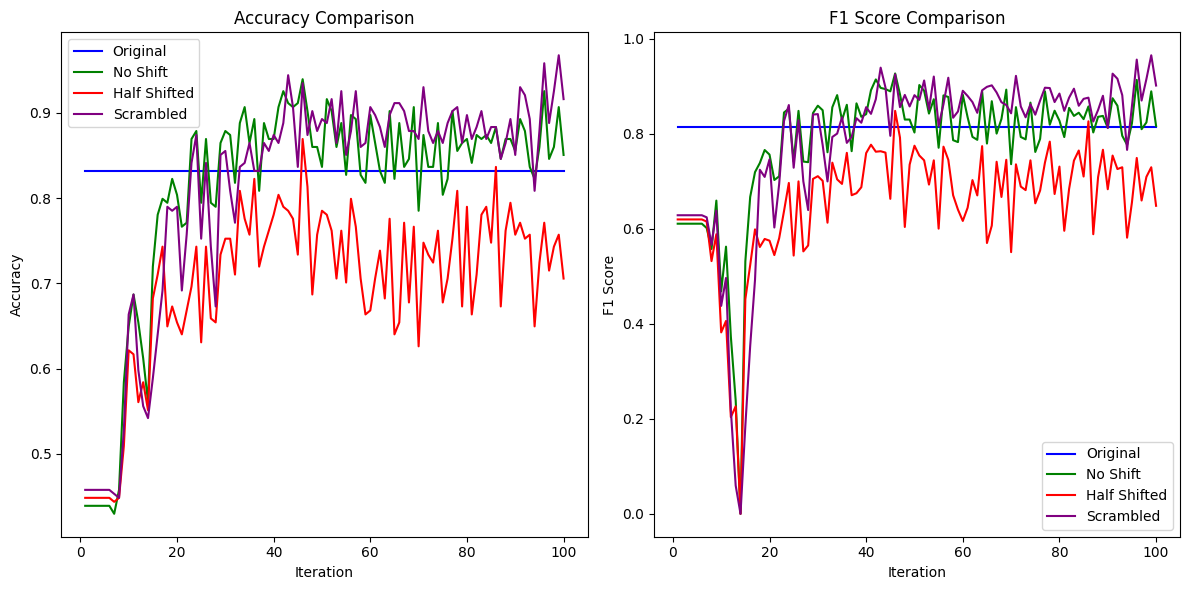

In [13]:
all_accuracies = []
all_f1_scores = []

for i in range(100):

    if i > 0:
        trainer_hub.train(trainset)

    causal_model = trainer_hub.ccnet
    test_data = torch.tensor(testset.X).float().to(device)
    test_label = torch.tensor(testset.y).float().to(device)
    one_hot_labels = torch.nn.functional.one_hot(test_label.to(torch.long), num_classes=2).float().squeeze(-2)

    # Get the explanation
    explanation = causal_model.explain(test_data)
    
    # Shift size to scramble the explanation
    shift_size = len(explanation)//2
    
    # Create synthetic datasets
    synthetic_data = [
        causal_model.produce(one_hot_labels, explanation),
        causal_model.produce(one_hot_labels, torch.cat((explanation[shift_size:], explanation[:shift_size]), dim=0)),
        causal_model.produce(one_hot_labels, (explanation / 2 + torch.cat((explanation[shift_size:], explanation[:shift_size]), dim=0) / 2))

    ]
    # Create the datasets with TemplateDataset class
    datasets = [TemplateDataset(test_data.cpu(), test_label.cpu())] + [
        TemplateDataset(data.cpu(), test_label.cpu()) for data in synthetic_data
    ]

    accuracies = []
    f1_scores = []
    # Test the model on the original and synthetic datasets
    for dataset in datasets:
        test_accuracy, test_f1 = test_model(model, dataset)
        accuracies.append(test_accuracy)
        f1_scores.append(test_f1)
    
    all_accuracies.append(accuracies)
    all_f1_scores.append(f1_scores)

    # Update the graph
    update_graph(all_accuracies, all_f1_scores, i)